Filtering Data with price, sqft living, grade

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [15]:
# Reading our csv file as dataframe
df = pd.read_csv('data/kc_house_data.csv')



In [16]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,17755.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000
mean,4580474287.77099,540296.57351,3.37320,2.11583,2080.32185,15099.40876,1.49410,1788.59684,1970.99968,83.63678,98077.95185,47.56009,-122.21398,1986.62032,12758.28351
std,2876735715.74778,367368.14010,0.92630,0.76898,918.10613,41412.63688,0.53968,827.75976,29.37523,399.94641,53.51307,0.13855,0.14072,685.23047,27274.44195
min,1000102.00000,78000.00000,1.00000,0.50000,370.00000,520.00000,1.00000,370.00000,1900.00000,0.00000,98001.00000,47.15590,-122.51900,399.00000,651.00000
25%,2123049175.00000,322000.00000,3.00000,1.75000,1430.00000,5040.00000,1.00000,1190.00000,1951.00000,0.00000,98033.00000,47.47110,-122.32800,1490.00000,5100.00000
50%,3904930410.00000,450000.00000,3.00000,2.25000,1910.00000,7618.00000,1.50000,1560.00000,1975.00000,0.00000,98065.00000,47.57180,-122.23100,1840.00000,7620.00000
75%,7308900490.00000,645000.00000,4.00000,2.50000,2550.00000,10685.00000,2.00000,2210.00000,1997.00000,0.00000,98118.00000,47.67800,-122.12500,2360.00000,10083.00000
max,9900000190.00000,7700000.00000,33.00000,8.00000,13540.00000,1651359.00000,3.50000,9410.00000,2015.00000,2015.00000,98199.00000,47.77760,-121.31500,6210.00000,871200.00000


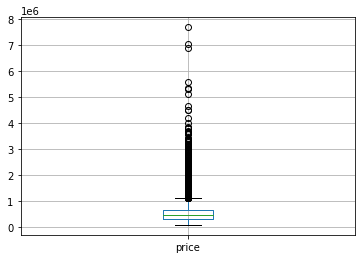

In [8]:
boxplot_price = df.boxplot(column = "price")
#Box Plot of the whole Price column

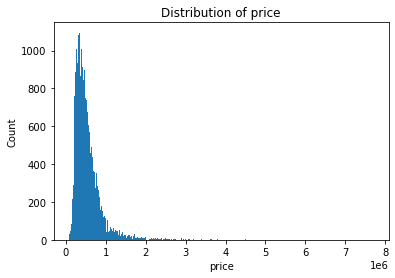

In [11]:
fig, ax = plt.subplots()
ax.hist(df["price"], bins="auto")
ax.set_xlabel("price")
ax.set_ylabel("Count")
ax.set_title("Distribution of price");
#Histogram of the whole Price Column

In [23]:
luxury_homes_overQ3 = df.loc[df['price'] >= 645000] #Using the Q3 statistic (645,000)
luxury_homes_overQ3 #When I used an arbitrary price 1,000,000, not enough data samples, only 1490 total houses. Jelly requires 5,000 samples. 

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5,7237550310,5/12/2014,1230000.00000,4,4.50000,5420,101930,1.00000,NO,NONE,...,11 Excellent,3890,1530.0,2001,0.00000,98053,47.65610,-122.00500,4760,101930
10,1736800520,4/3/2015,662500.00000,3,2.50000,3560,9796,1.00000,NaN,NONE,...,8 Good,1860,1700.0,1965,0.00000,98007,47.60070,-122.14500,2210,8925
15,9297300055,1/24/2015,650000.00000,4,3.00000,2950,5000,2.00000,NO,GOOD,...,9 Better,1980,970.0,1979,0.00000,98126,47.57140,-122.37500,2140,4000
21,2524049179,8/26/2014,2000000.00000,3,2.75000,3050,44867,1.00000,NO,EXCELLENT,...,9 Better,2330,720.0,1968,0.00000,98040,47.53160,-122.23300,4110,20336
26,1794500383,6/26/2014,937000.00000,3,1.75000,2450,2691,2.00000,NO,NONE,...,8 Good,1750,700.0,1915,nan,98119,47.63860,-122.36000,1760,3573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21580,7502800100,8/13/2014,679950.00000,5,2.75000,3600,9437,2.00000,NO,NONE,...,9 Better,3600,0.0,2014,0.00000,98059,47.48220,-122.13100,3550,9421
21581,191100405,4/21/2015,1580000.00000,4,3.25000,3410,10125,2.00000,NO,NONE,...,10 Very Good,3410,?,2007,nan,98040,47.56530,-122.22300,2290,10125
21583,7202300110,9/15/2014,810000.00000,4,3.00000,3990,7838,2.00000,NO,NONE,...,9 Better,3990,0.0,2003,nan,98053,47.68570,-122.04600,3370,6814
21584,249000205,10/15/2014,1540000.00000,5,3.75000,4470,8088,2.00000,NO,NONE,...,11 Excellent,4470,0.0,2008,0.00000,98004,47.63210,-122.20000,2780,8964


In [ ]:
#There are 5411 homes with the price over or equal to the Q3 statistic (75th percentile). 

In [20]:
luxury_homes_overQ3['price']

5       1230000.00000
10       662500.00000
15       650000.00000
21      2000000.00000
26       937000.00000
             ...     
21580    679950.00000
21581   1580000.00000
21583    810000.00000
21584   1540000.00000
21590   1010000.00000
Name: price, Length: 5411, dtype: float64

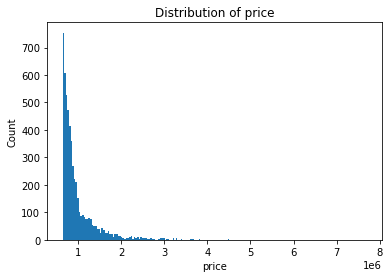

In [21]:
fig, ax = plt.subplots()
ax.hist(luxury_homes_overQ3['price'], bins="auto")
ax.set_xlabel("price")
ax.set_ylabel("Count")
ax.set_title("Distribution of price");
#histogram of luxy home prices